In [1]:
import numpy as np
import pandas as pd
#import sklearn as sk
import seaborn as sns
#import matplotlib.pyplot as plt


In [5]:
# DESCRIPTION

# The data presents user events from an online cosmetics store for October in 2019
# There are four event types: 'view', 'cart', 'remove-from-cart' and 'purchase'

# GOAL ... funnel analysis

# METHODS ... AIDA


In [128]:
data_set = pd.read_csv('2019-Oct.csv')

data_set = data_set.iloc[:,[0,1,2,7,8]]

#data_set['event_time'] = pd.to_datetime(data_set['event_time'])

data_set = data_set[data_set.iloc[:,4].notnull()]

In [160]:
# ASSUMPTIONS (1)


# Here you can see the assumptions based on which the code below is written.
# Some of them are taken because of the lack of information about how the website actually works

# 1) - The store is a typical website with the search bar for selling different items which has the main page and seperate 
# pages for all products

# 2) - A session ID is changed every time a user comes back to the store after a long pause

# 3) - To purchase an item users usually need to go through this path - view the item page, then add an item to the shopping 
# cart and buy it after getting on the shopping cart page.

# 4) - Using this piece of code you can see that the items added to the shopping cart in the previous sessions are saved in 
# the following ones so that the user journey is decreased and additional items can be added and bought without viewing them 
# just from the shopping cart.
 
data_set[data_set['event_time'].map(lambda x: x.day) > 10].drop_duplicates(['user_session']).head(50)



In [129]:
# ASSUMPTIONS (2)


# 5) - It's also possible that in addition to the button to add an item to the shopping cart an item page can have the button 
# to purchase an item directly from that page. It's another decreased user journey to utilize by users.

# 6) - In each session user events can be related to different products. For this reason in one session all different types of
# events are counted one time per product if happened.
#
# (If a user adds an item to the cart and then remove the item from it, this ation will be counted as 'cart'. And if 
# a user either browses a page, adds an item to the cart or purchases an item more than one time for the same product, each 
# event will be calculated only once.)
#
# It means the rows with the event type 'remove_from_cart' are not important for calculations


# Getting the data without the rows with the event type 'remove_from_cart'

data_set = data_set[data_set['event_type'] != 'remove_from_cart']

data_set.index = range(len(data_set))


In [161]:
%%time

data_for_pivot = data_set.iloc[:,[1,2,4]].copy()

data_for_pivot['event_types'] = data_set.iloc[:,1]



funnel_data = data_for_pivot \
.pivot_table('event_type', index = ['user_session','product_id'], columns = 'event_types', aggfunc = 'nunique').sum()

Wall time: 12.2 s



view        1607915
cart         982293
purchase     243820
dtype: int64

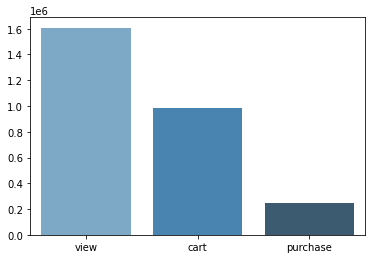

In [163]:
funnel_data = funnel_data[['view','cart','purchase']]

funnel_data = funnel_data.map(lambda x: int(x))

funnel_data.index.name = ''

sns.barplot(x = funnel_data.index, y = funnel_data.values, palette="Blues_d")

In [93]:
%%time

d = data_set.iloc[:100000,[1,2,4]]

g = d['event_type'].groupby([d['user_session'],d['product_id']])


event_names = pd.Series(['view','cart','purchase'])



def f(x):
    
    global event_name
    
    indicator = 0

    if event_name in x.values:
        
        indicator = 1
    
    return indicator



for i in range(3):
    
    event_name = event_names[i]
    
    if i == 0:
        
        first = g.agg(f)
        
    else:
        
        first = pd.concat([first,g.agg(f)], axis = 1)
        
first.columns = ['view','cart','purchase']
        
first.sum()

Wall time: 4.33 s


view        37749
cart        24393
purchase     6831
dtype: int64

In [12]:
%%time

d = data_set[:50000]

product_ids = pd.Series(d['product_id'])

product_ids.index = d['user_session']



event_types = pd.Series(d['event_type'])

event_types.index = d['user_session'] 



user_sessions = pd.Series(event_types.index.unique())



t_view = 0

t_cart = 0

t_purchase = 0


series_type = type(event_types)


for i in range(len(user_sessions)):
    
    
    if type(event_types[user_sessions[i]]) == series_type:
        
        session_events = event_types[user_sessions[i]]
        
        session_products = product_ids[user_sessions[i]]
        
    else:
        
        session_events = pd.Series(event_types[user_sessions[i]])
        
        session_events.index = [user_sessions[i]]
        
        session_products = pd.Series(product_ids[user_sessions[i]])
        
        session_products.index = [user_sessions[i]]
    
    
    uni_sess_products = pd.Series(session_products.unique())

    
    for j in range(len(uni_sess_products)):
        
        
        product_events = session_events[session_products == uni_sess_products[j]]
        
        if 'view' in product_events.values:
            
            t_view = t_view + 1
            
        if 'cart' in product_events.values:
            
            t_cart = t_cart + 1
            
        if 'purchase' in product_events.values:
            
            t_purchase = t_purchase + 1
            
print(t_view, t_cart, t_purchase)


18795 12030 3303
Wall time: 1min
